In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/',one_hot=False)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [86]:
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

In [87]:
Y_train=np.asarray(Y_train,dtype=np.int32)
Y_test=np.asarray(Y_test,dtype=np.int32)

In [88]:
X_train.shape

(55000, 784)

In [89]:
X_test.shape

(10000, 784)

In [90]:
Y_train[0]

7

Text(0.5, 1.0, 'O numero é 7')

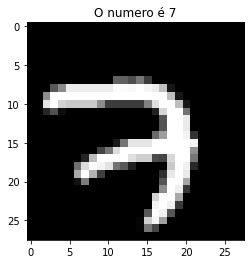

In [91]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0].reshape((28,28)),cmap='gray')
plt.title('O numero é '+str(Y_train[0]))

In [96]:
def cria_rede(features, labels, mode):
    #batch_size, largura, altura, canais(RGB)
    entrada = tf.reshape(features['X'],[-1,28,28,1])#-1 == None tf.placeholders
    
    #recebe {batch_size,28,28,1} 1 canal por ser cinza
    #retorna {batch_size,28,28,32} 32 mapas de caracteristicas 
    convolucao1 = tf.layers.conv2d(inputs=entrada, filters=32, kernel_size=[5,5],
                                  activation=tf.nn.relu, padding='same') #32 mapas de caracteristicas
    
    #simplifica quadrados de 2x2 pulando de 2 em 2
    #recebe {batch_size,28,28,32}
    #retorna {batch_size,14,14,32} com 32 'versoes' da imagem
    pooling1=tf.layers.max_pooling2d(inputs=convolucao1,pool_size=[2,2],strides=2) 
    
    #recebe {batch_size,14,14,32} 
    #retorna {batch_size,14,14,64} 
    convolucao2 = tf.layers.conv2d(inputs = pooling1, filters=64, kernel_size=[5,5],
                                    activation = tf.nn.relu, padding='same')
    #recebe {batch_size,14,14,64} 
    #retorna {batch_size,7,7,64} 
    pooling2=tf.layers.max_pooling2d(inputs=convolucao2,pool_size=[2,2],strides=2)
    
    #recebe {batch_size,-1,-1,64} 
    #retorna {batch_size,3136} 
    flattening = tf.reshape(pooling2, [-1,7*7*64])#transformar em array pra entrada em uma rede neural
    
    #3184 -> 1024 -> 10(saida)
    #recebe {batch_size,3136} 
    #retorna {batch_size,1024} 
    densa=tf.layers.dense(inputs=flattening,units=1024, activation=tf.nn.relu)
    
    #dropout
    dropout = tf.layers.dropout(inputs=densa,rate=0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    #recebe {batch_size,1024} 
    #retorna {batch_size,10} 
    saida=tf.layers.dense(inputs=dropout, units=10)
    
    #0.2 0.2 0.6
    
    previsoes = tf.argmax(saida, axis=1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=previsoes )
    
    erro = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=saida)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        otimizador = tf.train.AdamOptimizer(learning_rate=0.001)
        treinamento = otimizador.minimize(erro, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss=erro, train_op=treinamento)
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_ops={'accuracy':tf.metrics.accuracy(labels=labels, predictions=previsoes)}
        return tf.estimator.EstimatorSpec(mode = mode, loss=erro, eval_metric_ops=eval_metrics_ops)        

In [97]:
classificador = tf.estimator.Estimator(cria_rede)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\lukas\\AppData\\Local\\Temp\\tmpycro1in0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020B22288648>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [98]:
func_train = tf.estimator.inputs.numpy_input_fn(x={'X':X_train},y=Y_train,batch_size=128,
                                               num_epochs=None, shuffle=True)
classificador.train(input_fn=func_train,steps=200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\lukas\AppData\Local\Temp\tmpycro1in0\model.ckpt.
INFO:tensorflow:loss = 2.3017983, step = 1
INFO:tensorflow:global_step/sec: 4.52755
INFO:tensorflow:loss = 0.0880193, step = 101 (22.089 sec)
INFO:tensorflow:Saving checkpoints for 200 into C:\Users\lukas\AppData\Local\Temp\tmpycro1in0\model.ckpt.
INFO:tensorflow:Loss for final step: 0.12127311.


In [99]:
func_test= tf.estimator.inputs.numpy_input_fn(x={'X':X_test},y=Y_test, num_epochs=1, shuffle=False)
resultados = classificador.evaluate(input_fn=func_test)
resultados

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-01T15:20:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\lukas\AppData\Local\Temp\tmpycro1in0\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-10-01-15:20:07
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.9729, global_step = 200, loss = 0.08538556
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: C:\Users\lukas\AppData\Local\Temp\tmpycro1in0\model.ckpt-200


{'accuracy': 0.9729, 'loss': 0.08538556, 'global_step': 200}

In [100]:
X_image_teste = X_test[0]
X_image_teste.shape

(784,)

In [101]:
X_image_teste = X_image_teste.reshape(1,-1)
X_image_teste.shape

(1, 784)

In [102]:
func_previsao = tf.estimator.inputs.numpy_input_fn(x={'X':X_image_teste},shuffle=False)
pred = list(classificador.predict(input_fn=func_previsao))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\lukas\AppData\Local\Temp\tmpycro1in0\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 1.0, 'O numero é 7')

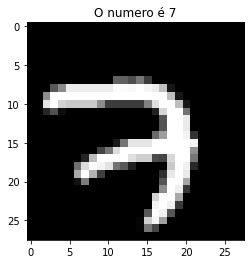

In [103]:
plt.imshow(X_train[0].reshape((28,28)),cmap='gray')
plt.title('O numero é '+str(pred[0]))